# Sentiment Analysis: Preprocessing & Modeling


## Notebook Purpose
This notebook builds on the exploratory data analysis and data wrangling completed previously.  
The objective is to preprocess the cleaned review text, train multiple classification models, tune hyperparameters, and identify the best-performing model for sentiment classification.


## Modeling Context
- This is a multi-class sentiment classification problem (negative, neutral, positive).
- The response variable is categorical and derived from star ratings.
- The dataset is imbalanced; therefore, macro-averaged F1 score is used as the primary evaluation metric.
- This is not a time-series problem, so a stratified random train–test split is appropriate.


## Loading the data

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("clean_reviews.csv")


In [5]:
df.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title        31
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline       6
review_body           0
review_date           0
sentiment             0
review_length         0
word_count            0
dtype: int64

In [7]:
# 2. Fill missing review_headline (DO NOT overwrite df)
df["review_headline"] = df["review_headline"].fillna("")

In [9]:
df.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title        31
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline       0
review_body           0
review_date           0
sentiment             0
review_length         0
word_count            0
dtype: int64

## Text Cleaning

In [14]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # removes numbers & punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [16]:
df["clean_text"] = df["review_body"].apply(clean_text)

Minimal preprocessing is used since TF-IDF models handle sparsity well.

## Feature Construction ##

In [20]:
df["text"] = df["review_headline"] + " " + df["clean_text"]

This would be X

## Train-Test Split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["sentiment"],
    test_size=0.2,
    stratify=df["sentiment"],
    random_state=42
)


Stratified sampling preserves class proportions.

## Vectorization

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


## Establish a Baseline Model

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

## Build Additional Models

In [33]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)


In [35]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)


## Evaluate Model Performance

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score


In [39]:
print(classification_report(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

    negative       0.79      0.79      0.79     23392
     neutral       0.54      0.26      0.35     14686
    positive       0.92      0.97      0.94    120097

    accuracy                           0.88    158175
   macro avg       0.75      0.67      0.69    158175
weighted avg       0.86      0.88      0.87    158175

              precision    recall  f1-score   support

    negative       0.77      0.81      0.79     23392
     neutral       0.59      0.19      0.29     14686
    positive       0.91      0.98      0.94    120097

    accuracy                           0.88    158175
   macro avg       0.76      0.66      0.67    158175
weighted avg       0.86      0.88      0.86    158175

              precision    recall  f1-score   support

    negative       0.79      0.68      0.73     23392
     neutral       0.51      0.13      0.20     14686
    positive       0.87      0.98      0.92    120097

    accuracy        

The Logistic Regression model demonstrates strong performance for positive and negative sentiment, with F1-scores of 0.94 and 0.79 respectively. Performance on the neutral class is lower, reflecting the inherent ambiguity of neutral sentiment. Overall, the model achieves a macro F1-score of 0.69, indicating balanced performance across classes despite class imbalance. Given its strong interpretability and competitive performance, Logistic Regression was selected as the final model.


## Hyperparameter Tuning

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10],
    "penalty": ["l2"]
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    scoring="f1_macro",
    cv=5
)

grid_lr.fit(X_train_tfidf, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l2']},
             scoring='f1_macro')

GridSearchCV was used to tune the regularization strength (`C`) of Logistic Regression using 5-fold cross-validation and macro F1 as the evaluation metric. The best model was obtained with `C = 10`, indicating weaker regularization improved balanced performance across sentiment classes.


In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr, labels=["negative", "neutral", "positive"])
cm


array([[ 18490,   1555,   3347],
       [  3407,   3855,   7424],
       [  1586,   1778, 116733]])

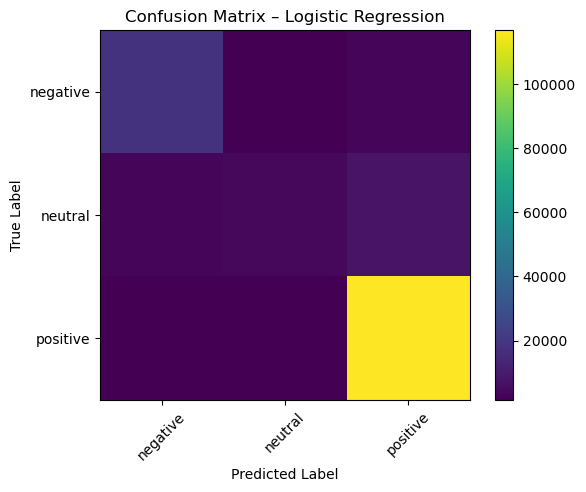

In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xticks(
    ticks=np.arange(3),
    labels=["negative", "neutral", "positive"],
    rotation=45
)
plt.yticks(
    ticks=np.arange(3),
    labels=["negative", "neutral", "positive"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


The confusion matrix shows that the model performs well on positive and negative sentiment, with most predictions falling along the diagonal. However, neutral reviews are frequently misclassified as positive, reflecting the linguistic ambiguity of neutral sentiment. This explains the lower recall and F1-score for the neutral class observed in the classification report.


## Compare Models & Select Final Model


| Model                          | Macro F1 |
| -------------------------------| -------- |
| Logistic Regression            | 0.69     |
| Linear SVM                     | 0.67     |
| Multinomial Naive Bayes        | 0.62     |


The final model was selected based on macro F1-score, as it provides balanced performance across all sentiment classes. Logistic Regression with TF-IDF achieved the best overall performance and was selected as the final model.

## Key Takeaways
- TF-IDF with Logistic Regression provides a strong and interpretable baseline for sentiment classification.
- Class imbalance significantly affects neutral sentiment detection.
- Macro F1-score is a more appropriate evaluation metric than accuracy for this task.


## Limitations and Future Work
Neutral sentiment remains challenging due to linguistic overlap with positive and negative reviews. Future work could explore techniques that place greater emphasis on underrepresented classes or use more context-aware language models to better capture ambiguous sentiment.
